In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint

%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv('TakeHome_task_data.csv')
pd.set_option('display.max_colwidth', -1)
df.head(5)

,data,label
0,"{'id': 'KG0OUA', 'data': 'Good morning', 'message_order': 2, 'comments': ['']}",location
1,"{'id': 'L9DC9H', 'data': 'Location', 'message_order': 5, 'comments': ['']}",whoAreYou
2,"{'id': 'ZQR6R5', 'data': 'hi', 'message_order': 5, 'comments': ['']}",whoAreYou
3,"{'id': 'RH0M4E', 'data': 'Hi', 'message_order': 4, 'comments': ['']}",greeting
4,"{'id': 'WLVX8I', 'data': 'Hello', 'message_order': 1, 'comments': ['']}",greeting


In [3]:
#obtaining the important parts of the data from the csv file i.e 'message', 'message_order', 'intent label'

ndf = df['data'].str.split(',')

ndata = list()
for i in range(ndf.size):
    ndata.append(ndf[i][1])
    
final_data = list()
for i in range(len(ndata)):
    final_data.append(ndata[i].split(':')[1])
    
m_order = list()
for i in range(ndf.size):
    if i in (75, 247, 458, 464, 631, 1269, 1459, 1601, 1651, 1803, 1918): #a bit crude but works for now
        m_order.append(ndf[i][3])
    else:
        m_order.append(ndf[i][2])
    
final_m_order = list()
for i in range(len(m_order)):
    final_m_order.append(m_order[i].split(':')[1])

    
data = pd.DataFrame(final_data, columns = ['text']).assign(message_order = final_m_order)
data = data.assign(label = df.label)
data.text = data.text.apply(str)
data.message_order = pd.to_numeric(data.message_order)

data.head(5)

,text,message_order,label
0,'Good morning',2,location
1,'Location',5,whoAreYou
2,'hi',5,whoAreYou
3,'Hi',4,greeting
4,'Hello',1,greeting


In [4]:
intent = data.label

In [5]:
#I want to look for any relations we can find using the message_order field

In [6]:
unique_intents = list(set(data.label))
unique_intents

['dontMeetRequirements', 'whoAreYou', 'greeting', 'location', 'notInterested']

In [7]:
data = data.replace({'location': 1,'whoAreYou': 2, 'greeting' : 3, 'dontMeetRequirements' : 4, 'notInterested' : 5})

In [8]:
#output pre_processed csv file
data.to_csv(r'pre_processed.csv')

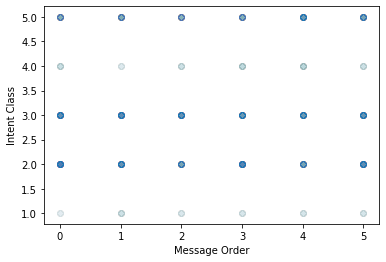

In [9]:
#Visualizing distribution of intent classification over message_orders (the dataset has fewer examples with class = 4,5)

x = np.array(data.message_order)
y = np.array(data.label)

plt.xlabel('Message Order')
plt.ylabel('Intent Class')

plt.scatter(x,y, alpha = 0.007)
plt.show()

In [10]:
message = np.array(data.text)
message_order = np.array(data.message_order)
labels = np.array(data.label)

for i in range(5):
    print('Examples of class ' + str(i+1) + ' =', np.sum(labels == i+1))

Examples of class 1 = 120
Examples of class 2 = 627
Examples of class 3 = 619
Examples of class 4 = 160
Examples of class 5 = 474


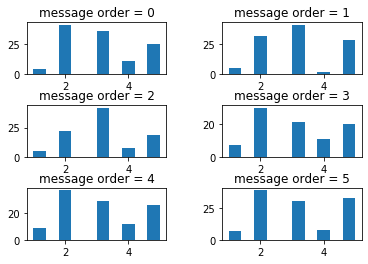

In [11]:
#To see if we can immediately spot any relation between the 'message' and 'message_order', let us vary
#one of them while holding the other constant and see the effect on intent class distribution

#Let us try to isolate the message 'hi' (600+ training examples) and see if we can find any relation between the
#assigned intent and message_order by keeping the text input from user constant i.e 'hi'

#if message_order is the order in which the message was sent by the user, then we would expect a lot of message_order = 0 
# 'hi' to be greetings.

#getting indices for messages that start with 'hi'
mask = []
for n,m in enumerate(message):
    m = m.lower()
    if m.startswith('h', 2):
        mask.append(n)

#now getting the intent class for various message_orders of the similar messages ('hi')
a = labels[mask]
for i in range(6):
    x = a[message_order[mask] == i]
    plt.subplot(3, 2, i+1)  
    plt.subplots_adjust(wspace = 0.4, hspace = 0.6)
    plt.title('message order = ' + str(i) )
    plt.hist(x)

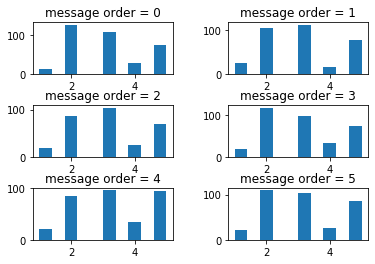

In [13]:
#Now we repeat the same procedure but this time keeping the message_order constant and checking labels for different msgs

for i in range(6):
    x = labels[message_order == i]
    plt.subplot(3, 2, i+1)  
    plt.subplots_adjust(wspace = 0.4, hspace = 0.6)
    plt.title('message order = ' + str(i) )
    plt.hist(x)


In [14]:
#There doesn't seem to be any plainly relevant relation/feature to be seen here so we shall proceed by implementing a model
#as per the usual plan without any special crafted features. Let us begin by preparing the data for numeric conversion

In [15]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
#shifting all data to lowercase and breaking sentences into word tokens

def cleaning(message):
    words = []
    for s in message:
        clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
        w = word_tokenize(clean)
        words.append([i.lower() for i in w])
    
    return words

In [17]:
cleaned_words = cleaning(message)
print(cleaned_words[5:10])

[['sir'], ['k'], ['on', 'thanks'], ['hii'], ['sir', 'i', 'dnt', 'have', 'two', 'wheeler']]


In [42]:
#standard keras tokenizer procedure

def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

In [43]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = len(max(cleaned_words, key = len))

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 812 and Maximum length = 19


In [44]:
#obtaining the word vectors

vectors = word_tokenizer.texts_to_sequences(cleaned_words)
vectors[0:4]

#using matrix decomposition of co-occurence matrix won't work well here clearly due to the nature of the 'corpus'.

[[16, 22], [11], [1], [1]]

In [45]:
#adding zero padding to make size of all vectors equal

def padding_doc(vectors, max_length):
  return(pad_sequences(vectors, maxlen = max_length, padding = "post"))

padded_doc = padding_doc(vectors, max_length)

In [46]:
#Adding message order as an input feature

message_order = message_order.reshape(2000,1)

padded_doc = np.append(padded_doc, message_order, axis=1)
padded_doc.shape

(2000, 20)

In [47]:
max_length = 20

In [48]:
#using one_hot representation for intent labels

labels = labels.reshape(2000,1)
labels.shape

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
Y_onehot = encoder.fit_transform(labels)
Y_onehot.shape

C:\Users\asus\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(2000, 5)

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, Y_onehot, shuffle = True, test_size = 0.2)

In [52]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (1600, 20) and train_Y = (1600, 5)
Shape of val_X = (400, 20) and val_Y = (400, 5)


In [29]:
#At this point we have our word vectors, output labels, training and validation datasets, and we can append the
#message_order value as a feature to the word vectors and feed the data to a model

In [30]:
#But our data is multilingual, to deal with that, we can first separate the data based on language and then train our model

In [53]:
#Using LSTM

def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(LSTM(128)))
#   model.add(LSTM(128))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(5, activation = "softmax"))
  
  return model

In [54]:
model = create_model(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 128)           103936    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
Total params: 375,493
Trainable params: 271,557
Non-trainable params: 103,936
_________________________________________________________________


In [55]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

hist = model.fit(train_X, train_Y, epochs = 100, batch_size = 32, validation_data = (val_X, val_Y), callbacks = [checkpoint])

Train on 1600 samples, validate on 400 samples
Epoch 1/100
1600/1600 [==============================] - 4s 2ms/step - loss: 1.5154 - acc: 0.2888 - val_loss: 1.4309 - val_acc: 0.3000

Epoch 00001: val_loss improved from inf to 1.43092, saving model to model.h5
Epoch 2/100
1600/1600 [==============================] - 2s 1ms/step - loss: 1.4792 - acc: 0.3050 - val_loss: 1.4397 - val_acc: 0.3000

Epoch 00002: val_loss did not improve from 1.43092
Epoch 3/100
1600/1600 [==============================] - 2s 1ms/step - loss: 1.4744 - acc: 0.3075 - val_loss: 1.4367 - val_acc: 0.3375

Epoch 00003: val_loss did not improve from 1.43092
Epoch 4/100
1600/1600 [==============================] - 2s 1ms/step - loss: 1.4643 - acc: 0.3319 - val_loss: 1.4278 - val_acc: 0.3075

Epoch 00004: val_loss improved from 1.43092 to 1.42776, saving model to model.h5
Epoch 5/100
1600/1600 [==============================] - 2s 1ms/step - loss: 1.4635 - acc: 0.3162 - val_loss: 1.4234 - val_acc: 0.3375

Epoch 00005: 


Epoch 00043: val_loss did not improve from 1.42099
Epoch 44/100
1600/1600 [==============================] - 2s 1ms/step - loss: 1.3072 - acc: 0.4100 - val_loss: 1.5295 - val_acc: 0.3350

Epoch 00044: val_loss did not improve from 1.42099
Epoch 45/100
1600/1600 [==============================] - 2s 1ms/step - loss: 1.2943 - acc: 0.4250 - val_loss: 1.5325 - val_acc: 0.3425

Epoch 00045: val_loss did not improve from 1.42099
Epoch 46/100
1600/1600 [==============================] - 3s 2ms/step - loss: 1.3125 - acc: 0.4288 - val_loss: 1.4918 - val_acc: 0.3625

Epoch 00046: val_loss did not improve from 1.42099
Epoch 47/100
1600/1600 [==============================] - 3s 2ms/step - loss: 1.2879 - acc: 0.4469 - val_loss: 1.5765 - val_acc: 0.3250

Epoch 00047: val_loss did not improve from 1.42099
Epoch 48/100
1600/1600 [==============================] - 2s 2ms/step - loss: 1.2965 - acc: 0.4338 - val_loss: 1.5194 - val_acc: 0.3475

Epoch 00048: val_loss did not improve from 1.42099
Epoch 49

In [35]:
#We see that even though the training loss is reducing, the validation loss is not and the model is only bit better
#than a randomly classifying model.

#There could be several reasons for that -

#1. Understanding the importance of message_order and its weight in decision making for classification. 

#2. Need for further pre-processing of data, such as dealing with multiple languages so that vector representations
#of the data are more accurate to semantics.

#3. The word vectors are very sparse and perhaps need more processing to better represent the data.

#4. There are 641 training examples with just the message 'hi' (or 'hello' or some variant). The curious thing 
#here is that for **entirely same inputs** i.e same (semantically) message 'hi' and same message_order, the assigned intents are all over
#the place. Different outputs for same input will make it hard to classify properly.

In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=1)

cross_val_score(clf, padded_doc, labels, cv = 5)

array([0.2244389 , 0.26932668, 0.2575    , 0.27      , 0.26130653])

In [37]:
#We see a slightly worse performance using Decision Tree.

#Although there is the difference between them that we have used only validation in one but cross-validation in the other.
#In case of same performance, we would have preferred the one that has used cross-validation.